In [16]:
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import mne
import mne_connectivity
import seaborn as sns
import matplotlib.pyplot as plt

import acareeg
from acareeg.eegip import get_mastersheet, get_resting_state_epochs

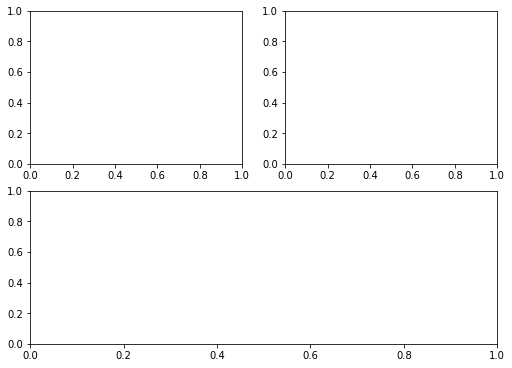

In [17]:
plt.rcParams['figure.facecolor'] = 'white'

fig = plt.figure(figsize=(7, 5), constrained_layout=True)
gs = fig.add_gridspec(2, 2)
# Create the Axes.
axes = [fig.add_subplot(gs[1, :]), fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]

# Computing the distribution of the number of epochs available for different epoch lenghts

In [18]:
recompute = False
save_file_name =  Path("epoch_length_effect.csv")

bids_root = Path("/Volumes/usc_data/ElementSE/eegip")

mastersheet = acareeg.eegip.get_mastersheet()
mastersheet = mastersheet.reset_index()[["Site", "ID", '6m_EEGLAB_QCR_File', 
                                         '12m_EEGLAB_QCR_File', '18m_EEGLAB_QCR_File']]
mastersheet = mastersheet.dropna(how="all")
mastersheet["subject_no"] = [int(subject[-3:]) 
                             if isinstance(subject, str) 
                             else subject 
                             for subject in mastersheet["ID"]]

if not save_file_name.exists() or recompute:
    duration2 = []
    duration4 = []
    duration1 = []
    duration1_raw = []
    subjects = []
    datasets = []
    ages = []
    for index, row in tqdm(list(mastersheet.iterrows())):
        dataset = row.Site.lower()
        for age in [6, 12, 18]:
            file_name = row[f"{age}m_EEGLAB_QCR_File"]
            if isinstance(file_name, str) and "qcr.se" in file_name:  # because .set is currently truncated for Washington
                subject = int(row.subject_no)
                age = int(age)
                eeg_path = Path(bids_root) / dataset / "derivatives" / "lossless" / f"sub-s{subject:03}" / f"ses-m{age:02}" / "eeg"
                eeg_path = list(eeg_path.glob("*_qcr.set"))
                if len(eeg_path) == 0:
                    continue
                eeg_path = eeg_path[0]                

                montage = mne.channels.make_standard_montage("GSN-HydroCel-129")            
                raw = acareeg.eegip.preprocessed_raw(eeg_path, acareeg.eegip.line_freqs[dataset], montage, 
                                                    apply_ica=False, verbose=False)
                
                events4 = acareeg.eegip.process_events_resting_state(raw, dataset, age, tmax=4)
                if events4 is None:
                    continue            
                epochs4 = acareeg.eegip.process_epochs(raw, dataset, age, events4, tmin=0, tmax=4, verbose=False)     
                
                events2 = acareeg.eegip.process_events_resting_state(raw, dataset, age, tmax=2)
                epochs2 = acareeg.eegip.process_epochs(raw, dataset, age, events2, tmin=0, tmax=2, verbose=False)

                events1 = acareeg.eegip.process_events_resting_state(raw, dataset, age, tmax=1)
                epochs1 = acareeg.eegip.process_epochs(raw, dataset, age, events2, tmin=0, tmax=1, verbose=False)            
                duration1_raw.append(len(events1)) 
                duration1.append(len(epochs1)*2)            
                duration2.append(len(epochs2)*2)
                duration4.append(len(epochs4)*4)
                assert(duration4[-1] <= duration2[-1])
                
                subjects.append(subject)
                ages.append(age)
                datasets.append(dataset)

    durations_df = pd.DataFrame(dict(duration2=duration2, duration4=duration4, 
                                    subject=subjects, age=ages, duration1=duration1,
                                    dataset=datasets, duration1_raw=duration1_raw))

    durations_df.to_csv(save_file_name)
else:
    durations_df = pd.read_csv(save_file_name)

The interval of confidence for a normally distributed variable is proportional to the standard error (se) around the mean, which is defined as following: 

$$ se = \frac{\sigma}{\sqrt{N}} $$

with $N$ being the sample size and $\sigma$ being the standard deviation.

Thus, to reduce the interval of confidence (i.e., the level of noise on an averaged variable) by a proportion $\alpha$, 
you need to increase the sample size by a proportion $\beta$ such that

$$ \alpha = \frac{se_2}{se_1} = \frac{\frac{\sigma}{\sqrt{\beta N}}}{\frac{\sigma}{\sqrt{N}}} = \frac{1}{\sqrt{\beta}} $$

So that to cut the interval of confidence in 2, you need a sample size 4 time larger; to cut it in 3, you need a sample size 9 times larger, ...


In [19]:
print(f"Mean recording duration available with 2s epochs: {durations_df.duration4.mean():.4}")
print(f"Mean recording duration available with 4s epochs: {durations_df.duration2.mean():.4}")
print(f"Average loss by using 4s epochs instead of 2s: {((durations_df.duration2 - durations_df.duration4)/durations_df.duration2*100).mean():.4}%")

beta = durations_df.duration2.mean()/durations_df.duration4.mean()
print(f"How much (in %) can the interval of confidence on the mean be reduced by using 2s epochs instead of 4s? In average {(1-1/np.sqrt(beta))*100:.4}%")
print(f"{np.sum(durations_df.duration4 == 0)} records get dropped with 4s because they have no epochs of that size.")


Mean recording duration available with 2s epochs: 107.6
Mean recording duration available with 4s epochs: 121.7
Average loss by using 4s epochs instead of 2s: 16.22%
How much (in %) can the interval of confidence on the mean be reduced by using 2s epochs instead of 4s? In average 5.958%
6 records get dropped with 4s because they have no epochs of that size.


In [20]:
for col in ["duration1", "duration1_raw"]:
    print(col)
    for (dataset, age), df in durations_df.groupby(["dataset", "age"]):
        print(dataset, age, f"{df.mean()[col]:.1f} ± {df.std()[col]:.1f} [{df.min()[col]}-{df.max()[col]}]")


duration1
london 6 34.1 ± 17.0 [2-78]
london 12 250.0 ± 106.2 [22-472]
washington 6 93.7 ± 41.8 [6-206]
washington 12 107.9 ± 47.6 [10-206]
washington 18 152.7 ± 59.6 [8-262]
duration1_raw
london 6 64.5 ± 26.3 [40-170]
london 12 395.8 ± 125.7 [66-734]
washington 6 144.8 ± 50.1 [56-236]
washington 12 157.9 ± 64.0 [31-333]
washington 18 205.6 ± 60.3 [56-334]


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_69990/2910659910.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(dataset, age, f"{df.mean()[col]:.1f} ± {df.std()[col]:.1f} [{df.min()[col]}-{df.max()[col]}]")
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_69990/2910659910.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(dataset, age, f"{df.mean()[col]:.1f} ± {df.std()[col]:.1f} [{df.min()[col]}-{df.max()[col]}]")


In [21]:
durations_df["dataset-age"] = [f"{dataset}-{age}" for dataset, age in zip(durations_df.dataset, durations_df.age)]

In [22]:
sns.histplot(x="duration1", hue="dataset-age", multiple="stack", data=durations_df, binwidth=10, ax=axes[0])
axes[0].axvline(x=20, color="k", linestyle="dashed")
axes[0].set_xlabel("Number of 1s epochs")
axes[0].set_xlim(left=0)
#plt.savefig("images/epoch_hist.png", dpi=300)

(0.0, 495.5)

# Compute connectivity values for different sample sizes

In [23]:
con_path = Path("/Volumes/usc_data/ElementSE/eegip/test_effect_nb_epochs/")
bids_root = Path("/Volumes/usc_data/ElementSE/eegip")

recompute = False

nb_iters = 10
con_name = "ciplv"
np.random.seed(324234)
mastersheet_df = get_mastersheet().reset_index()
nb_epochs_lst = np.round(np.logspace(np.log(3), np.log(100), 10, base=np.e)).astype(int)

for _, row in tqdm(list(mastersheet_df.iterrows())[:10], leave=False):
    for age in tqdm([6, 12, 18]):   

        file_name = con_path / f"{age}_{row['Site'].lower()}_{row['ID'].replace('EC', '')}_{con_name}.csv"

        if file_name.exists() and not recompute:
            continue 
        epochs = get_resting_state_epochs(row["ID"].replace("EC", ""), 
                                          row["Site"].lower(), age,
                                          bids_root=bids_root, tmax=1)
        if epochs is None:
            continue
            
        dfs = []
        for nb_epochs in tqdm(nb_epochs_lst):
            for _ in tqdm(list(range(nb_iters)), leave=False):
                if len(epochs) < nb_epochs:
                    continue
                inds = np.random.choice(np.arange(len(epochs)), nb_epochs, replace=True)

                con = mne_connectivity.spectral_connectivity_epochs(epochs[inds], method=con_name,
                                                                    sfreq=epochs.info["sfreq"],
                                                                    faverage=True, verbose=False)
                con = con.get_data("dense").squeeze()
                df = pd.DataFrame(con + np.triu(np.ones_like(con)*np.nan), 
                                  index=epochs.ch_names, 
                                  columns=epochs.ch_names)
                df = df.melt(ignore_index=False).dropna().reset_index()
                df.columns = ["ch1", "ch2", "con"]
                df["nb_epochs"] = nb_epochs        
                dfs.append(df)

        dat = pd.concat(dfs)
        dat["age"] = age
        dat["dataset"] = row["Site"].lower()
        dat["subject"] = row["ID"].replace("EC", "")
        dat.to_csv(file_name)      

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



/Users/christian/Code/acareeg/acareeg/eegip.py:154: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_eeglab(path, preload=True, verbose=verbose)
/Users/christian/Code/acareeg/acareeg/eegip.py:154: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(path, preload=True, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.6s finished
/Users/christian/Code/acareeg/acareeg/eegip.py:95: RuntimeWarning: Estimat

Applying ICA to Raw instance
    Transforming to ICA space (99 components)
    Zeroing out 29 ICA components
    Projecting back using 99 PCA components


/Users/christian/Code/acareeg/acareeg/eegip.py:147: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  read_ica_eeglab(file_name).apply(raw, exclude=ind_comp_to_drop)


  0%|          | 0/3 [00:00<?, ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    1.8s finished
/Users/christian/Code/acareeg/acareeg/eegip.py:95: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  info, _, _ = _get_info(raw_eeg)


Applying ICA to Raw instance
    Transforming to ICA space (107 components)
    Zeroing out 42 ICA components
    Projecting back using 107 PCA components


/Users/christian/Code/acareeg/acareeg/eegip.py:147: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  read_ica_eeglab(file_name).apply(raw, exclude=ind_comp_to_drop)


  0%|          | 0/3 [00:00<?, ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



/Users/christian/Code/acareeg/acareeg/eegip.py:154: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_eeglab(path, preload=True, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    2.4s finished
/Users/christian/Code/acareeg/acareeg/eegip.py:95: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  info, _, _ = _get_info(raw_eeg)


Applying ICA to Raw instance


/Users/christian/Code/acareeg/acareeg/eegip.py:147: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  read_ica_eeglab(file_name).apply(raw, exclude=ind_comp_to_drop)


    Transforming to ICA space (114 components)
    Zeroing out 83 ICA components
    Projecting back using 114 PCA components


  0%|          | 0/3 [00:00<?, ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



/Users/christian/Code/acareeg/acareeg/eegip.py:154: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_eeglab(path, preload=True, verbose=verbose)
/Users/christian/Code/acareeg/acareeg/eegip.py:154: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(path, preload=True, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    1.5s finished
/Users/christian/Code/acareeg/acareeg/eegip.py:95: RuntimeWarning: Estimat

Applying ICA to Raw instance
    Transforming to ICA space (102 components)
    Zeroing out 53 ICA components
    Projecting back using 102 PCA components


/Users/christian/Code/acareeg/acareeg/eegip.py:147: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  read_ica_eeglab(file_name).apply(raw, exclude=ind_comp_to_drop)


  0%|          | 0/3 [00:00<?, ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



/Users/christian/Code/acareeg/acareeg/eegip.py:154: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(path, preload=True, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.8s finished
/Users/christian/Code/acareeg/acareeg/eegip.py:95: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in differ

Applying ICA to Raw instance
    Transforming to ICA space (113 components)
    Zeroing out 35 ICA components
    Projecting back using 113 PCA components


/Users/christian/Code/acareeg/acareeg/eegip.py:147: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  read_ica_eeglab(file_name).apply(raw, exclude=ind_comp_to_drop)


  0%|          | 0/3 [00:00<?, ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



/Users/christian/Code/acareeg/acareeg/eegip.py:154: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_eeglab(path, preload=True, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    1.0s finished
/Users/christian/Code/acareeg/acareeg/eegip.py:95: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  info, _, _ = _get_info(raw_eeg)


Applying ICA to Raw instance
    Transforming to ICA space (107 components)
    Zeroing out 42 ICA components
    Projecting back using 107 PCA components


/Users/christian/Code/acareeg/acareeg/eegip.py:147: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  read_ica_eeglab(file_name).apply(raw, exclude=ind_comp_to_drop)


  0%|          | 0/3 [00:00<?, ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    1.3s finished
/Users/christian/Code/acareeg/acareeg/eegip.py:95: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  info, _, _ = _get_info(raw_eeg)


Applying ICA to Raw instance
    Transforming to ICA space (105 components)
    Zeroing out 52 ICA components
    Projecting back using 105 PCA components


/Users/christian/Code/acareeg/acareeg/eegip.py:147: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  read_ica_eeglab(file_name).apply(raw, exclude=ind_comp_to_drop)


  0%|          | 0/3 [00:00<?, ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



/Users/christian/Code/acareeg/acareeg/eegip.py:154: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_eeglab(path, preload=True, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    1.3s finished
/Users/christian/Code/acareeg/acareeg/eegip.py:95: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  info, _, _ = _get_info(raw_eeg)


Applying ICA to Raw instance
    Transforming to ICA space (99 components)
    Zeroing out 80 ICA components
    Projecting back using 99 PCA components


/Users/christian/Code/acareeg/acareeg/eegip.py:147: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  read_ica_eeglab(file_name).apply(raw, exclude=ind_comp_to_drop)


  0%|          | 0/3 [00:00<?, ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    1.1s finished
/Users/christian/Code/acareeg/acareeg/eegip.py:95: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  info, _, _ = _get_info(raw_eeg)


Applying ICA to Raw instance
    Transforming to ICA space (108 components)
    Zeroing out 37 ICA components
    Projecting back using 108 PCA components


/Users/christian/Code/acareeg/acareeg/eegip.py:147: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  read_ica_eeglab(file_name).apply(raw, exclude=ind_comp_to_drop)


  0%|          | 0/3 [00:00<?, ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    1.3s finished
/Users/christian/Code/acareeg/acareeg/eegip.py:95: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  info, _, _ = _get_info(raw_eeg)


Applying ICA to Raw instance
    Transforming to ICA space (108 components)
    Zeroing out 75 ICA components
    Projecting back using 108 PCA components


/Users/christian/Code/acareeg/acareeg/eegip.py:147: RuntimeWarning: Estimated head radius (10138.0 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  read_ica_eeglab(file_name).apply(raw, exclude=ind_comp_to_drop)


### Showing the systematic effect of sample size on connectivity values

In [24]:
con_path = Path("/Volumes/usc_data/ElementSE/eegip/test_effect_nb_epochs/")

dfs = []
for con_name in ["ciplv"]:
    df = pd.concat([pd.read_csv(path) for path in con_path.glob(f"*_{con_name}.csv")])
    df["measure"] = con_name
    dfs.append(df)
df_effect_nb_epochs = pd.concat(dfs)

In [25]:
sns.lineplot(x="nb_epochs", y="con", data=df_effect_nb_epochs, ax=axes[1])
axes[1].set_xlabel("Number of 1s epochs")
axes[1].set_ylabel("CIPLV")
axes[1].axvline(x=20, linestyle="dashed", color="k")
axes[1].set_xlim(0, 100)
axes[1].set_ylim(0.1, 0.4)
#plt.savefig("images/epoch_nb_bias_CIPLV.png", dpi=300)

(0.1, 0.4)

# Computing the STD of bootstrapped estimates of functional connectivity for wpli and ciplv

This is an example using only one subject. This subject has been chosen randomly (i.e., not cherry-picked).

In [26]:
subject_no = 2
dataset = "washington"
age = 12

In [27]:
fmin = (3, )
fmax = (100, )
bands = ("broadband", )
con_names = ("ciplv", "wpli")
mode = 'multitaper'

common_template_age = 12
tmax = 1.0
min_nb_epochs = 20
np.random.seed(324234)
con_path = Path("/Volumes/usc_data/ElementSE/eegip/test_reliability/")
bids_root = Path("/Volumes/usc_data/ElementSE/eegip")
subjects_dir = "."

epochs = acareeg.eegip.get_resting_state_epochs(subject_no, dataset, age, 
                                                bids_root=bids_root,
                                                tmax=tmax)
epochs.set_eeg_reference(projection=True)
sources_age = common_template_age

# Currently, we don't include the volume sources because there is no way to simulate
# with mixed source models.                    
label_ts, anat_label = acareeg.infantmodels.compute_sources(epochs, sources_age, 
                                                            subjects_dir=subjects_dir, 
                                                            return_labels=True, return_xr=False, loose=0, 
                                                            fixed=True, inv_method="eLORETA", pick_ori=None,
                                                            lambda2=1e-4, minimal_snr=None, verbose=False, 
                                                            include_vol_src=False)          
label_names = np.array([label.name for label in anat_label])
sfreq = epochs.info['sfreq']            

label_ts = np.array(label_ts)
n = np.array(label_ts).shape[0]

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



/Users/christian/Code/acareeg/acareeg/eegip.py:154: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(path, preload=True, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    4.8s finished
/Users/christian/Code/acareeg/acareeg/eegip.py:95: RuntimeWarning: Estimated head radius (10101.3 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in differ

Applying ICA to Raw instance


/Users/christian/Code/acareeg/acareeg/eegip.py:147: RuntimeWarning: Estimated head radius (10101.3 cm) is above the 99th percentile for adult head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  read_ica_eeglab(file_name).apply(raw, exclude=ind_comp_to_drop)


    Transforming to ICA space (100 components)
    Zeroing out 87 ICA components
    Projecting back using 100 PCA components
Not setting metadata
222 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 222 events and 500 original time points ...
45 bad epochs dropped
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
0 files missing from ANTS12-0Months3T.txt in /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T
    3 BEM surfaces found
    Reading a surface...
[done]
    Reading a surface...
[done]
    Reading a surface...
[done]
    3 BEM surfaces read
Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from /Users/christian/Code/papers/asd_infants_eeg_co

/Users/christian/Code/acareeg/acareeg/infantmodels.py:192: RuntimeWarning: Not setting positions of 10 eog channels found in montage:
['E1', 'E8', 'E14', 'E21', 'E25', 'E32', 'E125', 'E126', 'E127', 'E128']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  epochs.set_montage(montage)


Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  832/4098 points inside  an interior sphere of radius   38.5 mm
    Found    0/4098 points outside an exterior sphere of radius   76.9 mm
    Found    0/3266 points outside using surface Qhull


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found    0/3266 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 4208.2 ms
    131 source space point omitted because of the    5.0-mm distance limit.
    Computing patch statistics...
    Patch information added...
Checking surface interior status for 4098 points...
    Found  829/4098 points inside  an interior sphere of radius   38.5 mm
    Found    0/4098 points outside an exterior sphere of radius   76.9 mm
    Found    0/3269 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found    0/3269 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 4201.1 ms
    102 source space point omitted because of the    5.0-mm distance limit.
    Computing patch statistics...
    Patch information added...

Setting up for EEG...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished


Computing EEG at 7963 source locations (free orientations)...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s finished


Computing rank from data with rank=None
    Using tolerance 6.6e-10 (2.2e-16 eps * 119 dim * 2.5e+04  max singular value)
    Estimated rank (eeg): 13
    EEG: rank 13 computed from 119 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 119 -> 13
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 88500
log-likelihood on unseen data (descending order):
   shrunk: -54.494
   empirical: -54.499
   diagonal_fixed: -56.183
selecting best estimator: shrunk
[done]
Computing inverse operator with 119 channels.
    119 out of 119 channels remain after picking
Selected 119 channels
Creating the depth weighting ma

In [28]:
recompute = False

for i in tqdm(list(range(100))):
    for con_name in con_names:
        path_out = con_path / f"{subject_no}_{dataset}_{age}_{con_name}_{common_template_age}m-template_{i}.csv"

        if path_out.exists() and not recompute:
            continue
        
        con_df = []       
        sample = label_ts[np.random.choice(range(n), n, replace=True), :, :]
        con = mne_connectivity.spectral_connectivity_epochs(sample, 
                                                            method=con_name,
                                                            mode=mode, sfreq=sfreq, fmin=fmin,
                                                            fmax=fmax, faverage=True, verbose=False)
        dfs = [] 
        for mat, band in zip(con.get_data("dense").transpose(2, 0, 1), bands):
            mat = pd.DataFrame(mat) + np.triu(mat * np.nan)
            mat.index = label_names
            mat.columns = label_names
            df = mat.reset_index().melt(id_vars="index").dropna()
            df.columns = ["region1", "region2", "con"]
            df["con_name"] = con_name
            df["band"] = band
            df["age"] = age
            dfs.append(df)

        pd.concat(dfs).to_csv(path_out)

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
con_path = Path("/Volumes/usc_data/ElementSE/eegip/test_reliability/")

df_reliability = pd.concat([pd.read_csv(f, index_col=0) for f in list(con_path.glob("*"))])

for con_name in df_reliability.con_name.unique():
    cond = df_reliability.con_name == con_name
    sns.kdeplot(data=df_reliability[cond].groupby(["region1", "region2"])
                                         .std()["con"]
                                         .reset_index(),
                x="con", fill=True, ax=axes[2], label=con_name)
axes[2].set_xlabel("STD of connectivity measures")
axes[2].legend()



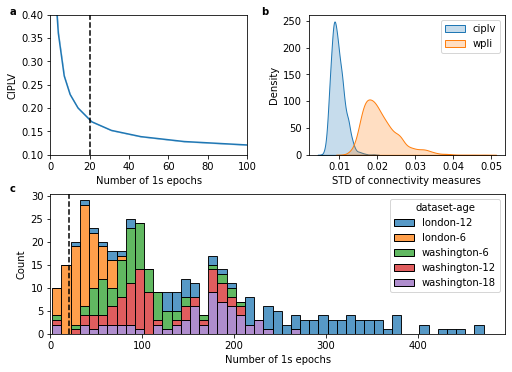

In [30]:
fig.text(0.01, 0.98, "a", fontweight="bold")    
fig.text(0.51, 0.98, "b", fontweight="bold")    
fig.text(0.01, 0.49, "c", fontweight="bold")       
fig.savefig("images/supp_method_fig1.png", dpi=300)

fig